In [1]:
import sys
if not "../src" in sys.path:
    sys.path.append("../src")

import pandas as pd
import seaborn as sns

import genpred

METRIC = "accuracy"

def collect_performance(task, vectorizer, vocab_size, partition="test", metric_name=METRIC):
    root = genpred.EXPS_ROOT / task / vectorizer / f"{vocab_size}"
    metrics = pd.read_csv(root / "metrics.csv")
    return metrics[f"{partition}_{metric_name}"].values[0]


def collect_all_performances(task, partition="test"):
    root = genpred.EXPS_ROOT / task
    
    all_performances = []
    for vectorizer in ["kmer", "sentencepiece"]:
        subfolder = root / vectorizer
        vocab_sizes_folder = sorted(subfolder.iterdir())
        for vocab_size_path in vocab_sizes_folder:
            vocab_size = int(vocab_size_path.stem)
            
            performances = {
                "Task": task.capitalize(),
                "Method": vectorizer.capitalize(),
                "Vocab. size": vocab_size,
            }
            for metric_name in ["accuracy", "roc_auc", "matthews_corrcoef"]:
                value = collect_performance(
                    task, 
                    vectorizer, 
                    vocab_size, 
                    partition=partition, 
                    metric_name=metric_name
                )
                hname = metric_name.replace("_", " ").upper()
                performances[hname] = value

            all_performances.append(performances)
    
    return pd.DataFrame(all_performances)


# Model selection

We provide details about the model selection. All experiments have been performed using the `lightGBM` (lGBM) implementation Gradient Boosting Machines as classifier. In each model training, we test 50 different lGBM models (identical across the different experiments), whose hyper-parameters are chosen at random with Randomized Grid Search. Below, we list the 50 combinations of hyper-parameters tested:

In [2]:
def load_hyperparameters():
    cv_results = pd.read_csv(genpred.EXPS_ROOT / "disease/sentencepiece/32000/cv_results.csv")
    return cv_results[[c for c in cv_results.columns if "param_" in c]]  

load_hyperparameters()

,param_classifier__max_bin,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__num_leaves
0,16,9,1716,83
1,31,7,1883,25
2,23,9,1099,86
3,28,4,1920,74
4,5,4,1349,181
5,29,9,572,25
6,24,7,1476,213
7,19,4,1350,115
8,28,5,1255,45
9,23,7,1410,183


## Experimental setup

We designed two set of experiments, one for the `capsule` task and one for the `disease` task. For each task, we compare two different approaches to represent a _Neisseria meningitidis_ genome as a bag of words:

- the first approach is to segment the genome in $k$-mers, where $k$ varies incrementally in the range $(3,8)$. We evaluate 6 variants of this approach:
    - only $3$-mers (vocabulary size: 64)
    - $3$ and $4$-mers (vocabulary size: 320)
    - $3$, $4$, and $5$-mers (vocabulary size: 1344)
    - $3$, $4$, $5$, and $6$-mers (vocabulary size: 5400)
    - $3$, $4$, $5$, $6$, and $7$-mers (vocabulary size: 21824)
    - $3$, $4$, $5$, $6$, $7$, and $8$-mers (vocabulary size: 87360)

- the second approach is based on SentencePiece. We evaluate 6 variants:
    - 2000 words vocabulary
    - 4000 words vocabulary
    - 8000 words vocabulary
    - 16000 words vocabulary
    - 32000 words vocabulary
    - 64000 words vocabulary

For each variant, the 50 models above are trained on the training set and their performance validated on the validation set (see the `preprocessing.ipynb` notebook). On the validation set, we compute three different metrics: `accuracy`, AUROC (`roc_auc`), and Matthews correlation coefficient (`mcc`). After all 50 models are trained, we choose the one with the best validation accuracy, train it using the training set plus the validation set, and test its performances on the test set, where we compute the same set of metrics.

## Model evaluation for the `capsule` task

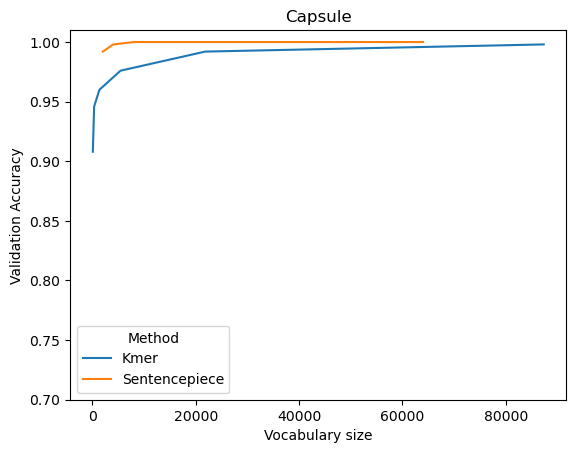

In [3]:
capsule_performances = collect_all_performances("capsule", partition="val")
ax = sns.lineplot(data=capsule_performances, x="Vocab. size", y="ACCURACY", hue="Method")
ax.set_ylim([0.7, 1.01])
ax.set_ylabel("Validation Accuracy")
ax.set_xlabel("Vocabulary size")
ax.set_title("Capsule");

The plot above shows the performance of the $k$-mer and SentencePiece variants trained on the `capsule` data. As we can see, the SentencePiece approach is capable of reaching 1.0 accuracy on the validation set using as little vocabulary size as 8000, while the $k$-mer approach needs a vocabulary size of 87360 to reach approximately the same accuracy (0.998). Below, the full detail of the experiments for the three metrics.

In [4]:
capsule_performances = capsule_performances.sort_values(["Method", "Vocab. size"]).drop("Task", axis=1).reset_index(drop=True)
capsule_performances.to_csv("fig4_panelA.csv", index=False)

For the table above, it is clear that the best model for this task is the one with vocabulary size 8000. Thus, we proceed to evaluate it on the test set, obtaining the result below:

In [5]:
capsule_performances = collect_all_performances("capsule", partition="test")
capsule_performances[(capsule_performances.Method=="Sentencepiece") & (capsule_performances["Vocab. size"] == 8000)]

,Task,Method,Vocab. size,ACCURACY,ROC AUC,MATTHEWS CORRCOEF
11,Capsule,Sentencepiece,8000,0.996,1.0,0.992


In the following analysis (assessing the impact of the capsule removal), we are going to use this model.

## Model selection for the `disease` task

For the `disease` task, we are going to repeat a similar analysis. First, we plot the accuracies of the two approaches on the validation set as the vocabulary size changes:

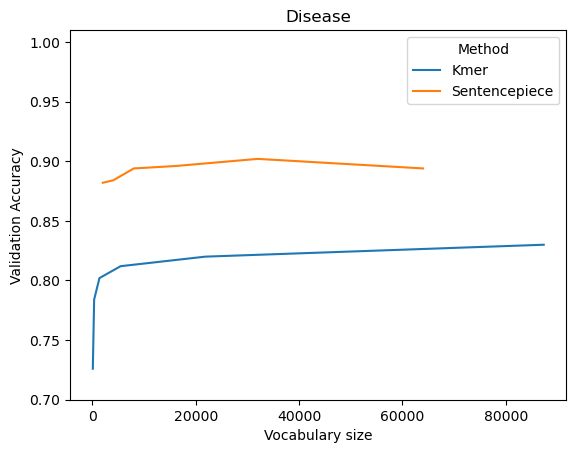

In [6]:
disease_performances = collect_all_performances("disease", partition="val")
ax = sns.lineplot(data=disease_performances, x="Vocab. size", y="ACCURACY", hue="Method")
ax.set_ylim([0.7, 1.01])
ax.set_ylabel("Validation Accuracy")
ax.set_xlabel("Vocabulary size")
ax.set_title("Disease");

As we can see, the Sentencepiece approach is still superior to the $k$-mer approach, this time with a wider margin. Below, we show the entire set of performances:

In [7]:
disease_performances = disease_performances.sort_values(["Method", "Vocab. size"]).drop("Task", axis=1).reset_index(drop=True)
disease_performances.to_csv("fig4_panelB.csv", index=False)

In this case, the model with the best validation accuracy is Sentencepiece with a vocabulary size of 32000. We proceed to test this model on the test set and record its performances:

In [8]:
disease_performances = collect_all_performances("disease", partition="test")
disease_performances[(disease_performances.Method == "Sentencepiece") & (disease_performances["Vocab. size"] == 32000)]

,Task,Method,Vocab. size,ACCURACY,ROC AUC,MATTHEWS CORRCOEF
8,Disease,Sentencepiece,32000,0.902,0.968,0.804


Once again, the Sentencepiece approach has outperformed the $k$-mer approach and has yielded strong out-of-sample performance. In the following analysis (assessing the impact of the gene knock-out), we are going to use this model.